In [255]:
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.stats
import sklearn.metrics
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN, KMeans
import os
import re
import pylab as pl
import seaborn as sns

%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 5
pd.__version__, sklearn.__version__, np.__version__

('0.17.1', '0.17', '1.10.4')

In [254]:
def memory_usage(df, ret=False, print_usage=True):
    if type(df) == pd.core.frame.DataFrame:
        m = df.memory_usage(index=True, deep=True).sum()/2**20
    elif type(df) == np.ndarray:
        m = df.nbytes/2**20
    if print_usage:
        print(m, 'Mb,', 'with shape =', df.shape)
    if ret:
        return m

In [256]:
def read_tosvmr(filename):
    if os.stat(filename).st_size == 0:
        return None
    df = pd.read_csv(filename, sep=' ', header=None)
    del df[7], df[6]
    df.columns = ['Rank', 'QueryID', 'CTR', 'CTP',
                  'Purchases', 'Turnover', 'ItemID']
    df.QueryID = df.QueryID.str.extract('qid:(\d+)').astype('int32')
    df.Rank = df.Rank.astype('int8')
    for i, col in enumerate(['CTR', 'CTP', 'Purchases', 'Turnover']):
        df[col] = df[col].str.extract(str(i+1) + ':(.+)').astype('float16')
    df.ItemID = df.ItemID.str.extract('item_id=(.+)')
    return df

In [4]:
# data = pd.DataFrame()
# directory = '../data/svmr/'
# size = 0
# records = 0
# max_Rank, max_QID, max_ItemID_len = 0, 0, 0 # (2, 309111, 36)
# min_Rank, min_QID, min_ItemID_len = (2**63-1,)*3 # (1, 2, 36)
# for i, filename in enumerate([f for f in os.listdir(directory) if re.match('.+\.tosvmr', f)]):
#     chunk = read_tosvmr(os.path.join(directory, filename))
#     if chunk is not None:
# #         data = data.append(chunk)
#         size += memory_usage(chunk, ret=True, print_usage=False)
#         records += chunk.shape[0]
#         max_Rank = max(max_Rank, chunk.Rank.max())
#         min_Rank = min(min_Rank, chunk.Rank.min())
#         max_QID = max(max_QID, chunk.QueryID.max())
#         min_QID = min(min_QID, chunk.QueryID.min())
#         max_ItemID_len = max(max_ItemID_len, chunk.ItemID.str.len().max())
#         min_ItemID_len = min(min_ItemID_len, chunk.ItemID.str.len().min())
#     if i % 10 == 0:
#         print(i+1, 'file', filename)
#         print('overall', size, 'Mb', 'records =', records)
#     del chunk
# print('TOTAL', size, (max_Rank, max_QID, max_ItemID_len), (min_Rank, min_QID, min_ItemID_len))


In [257]:
data = read_tosvmr('../data/svmr/111AF73E-67E3-4E6E-BB32-3A7FB9B2F08A.tosvmr')
memory_usage(data)
data.head()

130.4436206817627 Mb, with shape = (1199825, 7)


,Rank,QueryID,CTR,CTP,Purchases,Turnover,ItemID
0,1,50,0.000000,0,0.000000,0.000000,C415ECF5-A793-4FD8-94B9-01D5FB49059D
1,1,50,0.000084,0,0.000000,0.000000,6ECB11C9-F5FA-43F8-9EB8-02EA2D9F8655
2,1,50,0.000095,0,0.000000,0.000000,1677733D-B6CF-4AC4-BC1F-0392269E50B4
3,1,50,0.000139,0,0.000000,0.000000,EF2D920A-3C31-48CA-96C0-04A10616EBD6
4,1,50,0.000324,0,0.002375,0.001271,3C926EEF-ABEA-464F-8C93-082C57259443


In [258]:
queryID_encoder, itemID_encoder = LabelEncoder(), LabelEncoder()
S = scipy.sparse.coo_matrix((data.Rank.values, 
                             (queryID_encoder.fit_transform(data.QueryID.values),
                              itemID_encoder.fit_transform(data.ItemID.values)))).tocsr()
S

<7464x10820 sparse matrix of type '<class 'numpy.int8'>'
	with 1199825 stored elements in Compressed Sparse Row format>

In [259]:
def kendalltau_distance(x, y):
    mask_x = np.in1d(x.indices, y.indices)
    mask_y = np.in1d(y.indices, x.indices)
    vector_x = x.data[mask_x]
    vector_y = y.data[mask_y]
    if np.unique(vector_x).shape[0] == 1 or np.unique(vector_y).shape[0] == 1:
        vector_x = np.append(vector_x, [0])
        vector_y = np.append(vector_y, [0])
    if mask_x.sum() == 0:
        tau = 0
    else:
        tau, pvalue = scipy.stats.kendalltau(vector_x, vector_y)
    return 2 - tau - mask_x.sum()/np.max([x.data.shape[0], y.data.shape[0]])

In [ ]:
distance_matrix = sklearn.metrics.pairwise_distances(S, metric=kendalltau_distance)
print(np.isnan(distance_matrix).any())
memory_usage(distance_matrix) 

# KMeans with SVD and euclidian metric

In [13]:
u,s,v = scipy.sparse.linalg.svds(S.astype('f'), k=10)
u.shape, s.shape, v.shape

((7464, 20), (20,), (20, 10820))

2 0.474663347006
3 0.189297035336
4 0.24015159905
5 0.286334067583
6 0.272199928761
7 0.311545163393
8 0.337563544512
9 0.405959486961
10 0.438909441233
11 0.487679064274
12 0.472795069218
13 0.509598493576
14 0.519469320774
15 0.533808588982
16 0.538330078125
17 0.545993804932
18 0.552761018276
19 0.549850463867
20 0.557537794113
21 0.5764336586
22 0.556819319725
23 0.556168675423
24 0.568443477154
25 0.56238591671
26 0.578886389732
27 0.575040400028
28 0.568774580956
29 0.577990055084
30 0.573342169943


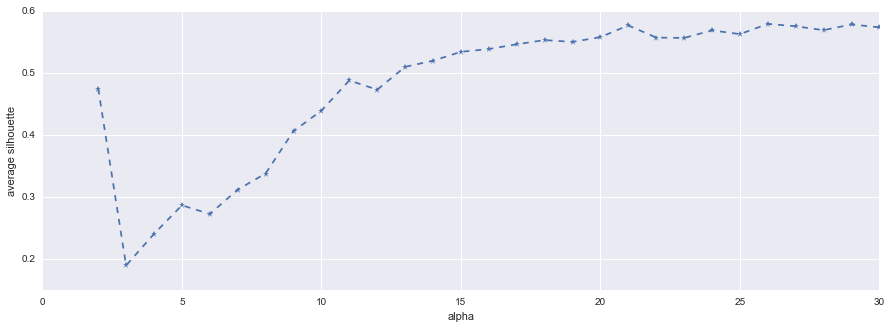

In [14]:
ks = np.arange(2,25)
silhouettes = np.zeros(ks.shape[0])
for i, k in enumerate(ks):
    clustering = KMeans(n_clusters=k)
    labels = clustering.fit_predict(u)
    silhouettes[i] = sklearn.metrics.silhouette_score(u, labels)
    print(k, silhouettes[i])
pl.plot(ks, silhouettes, '--*')
pl.xlabel('alpha')
pl.ylabel('average silhouette')

In [15]:
def plot_silhouettes(silhouette_values, labels, n_clusters):
    pl.figure(figsize=(15, 20))
    pl.title(str(n_clusters) + ' clusters. Avg silhouette =' + ('%.5f' % silhouette_values.mean()))
    y_lower = 20
    for i in range(n_clusters):
        cluster_silhouette_values = np.sort(silhouette_values[labels == i])
        y_upper = y_lower + cluster_silhouette_values.shape[0]

        cluster_silhouette_values = np.sort(silhouette_values[labels == i])
        pl.fill_betweenx(np.arange(y_lower,y_upper),
                           0, cluster_silhouette_values, facecolor=pl.cm.spectral(i/n_clusters), alpha=0.6)
        pl.text(-0.05, y_lower + 0.5 * cluster_silhouette_values.shape[0], str(i))
        y_lower = y_upper + 10
    pl.axvline(x=silhouette_values.mean(), color="red", linestyle="--")    

/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


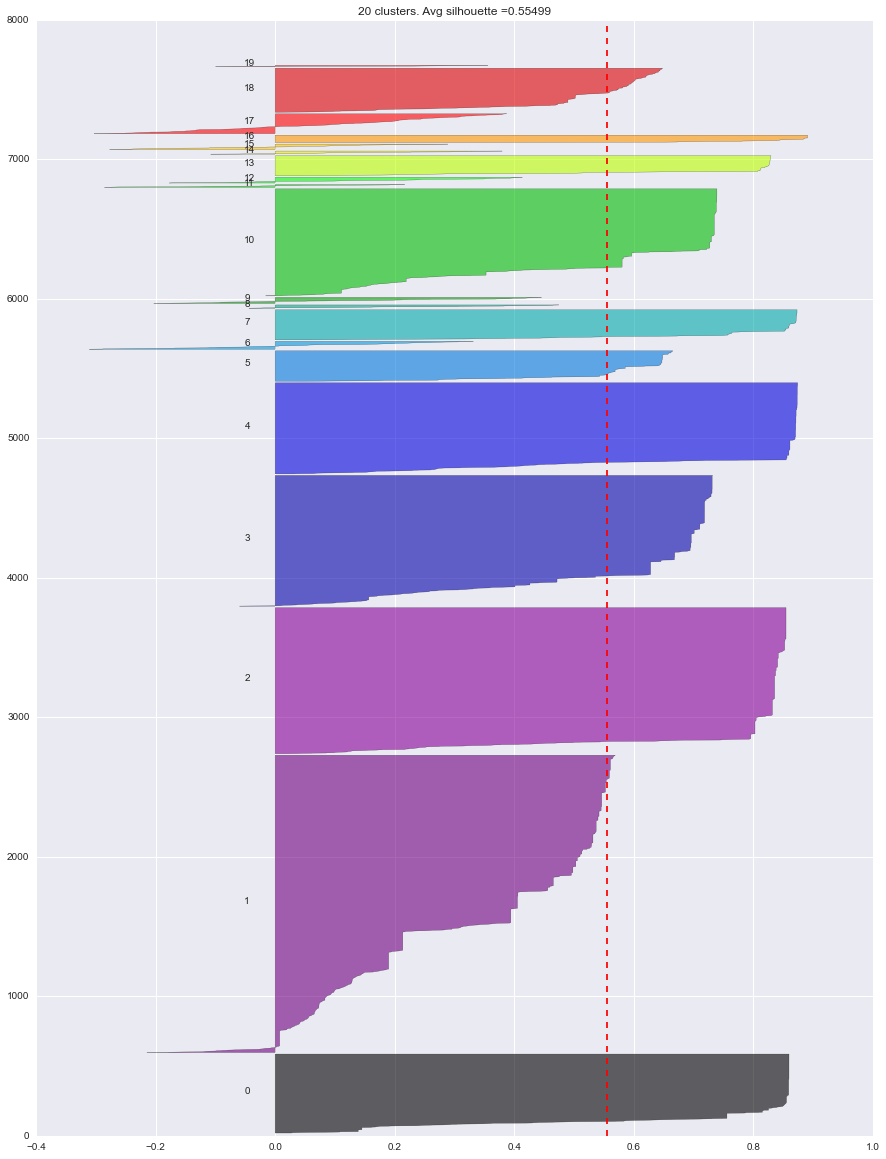

In [18]:
n_clusters = 20
clustering = KMeans(n_clusters=n_clusters)
labels = clustering.fit_predict(u)
silhouette_values = sklearn.metrics.silhouette_samples(u, labels)
plot_silhouettes(silhouette_values, labels, n_clusters)


/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


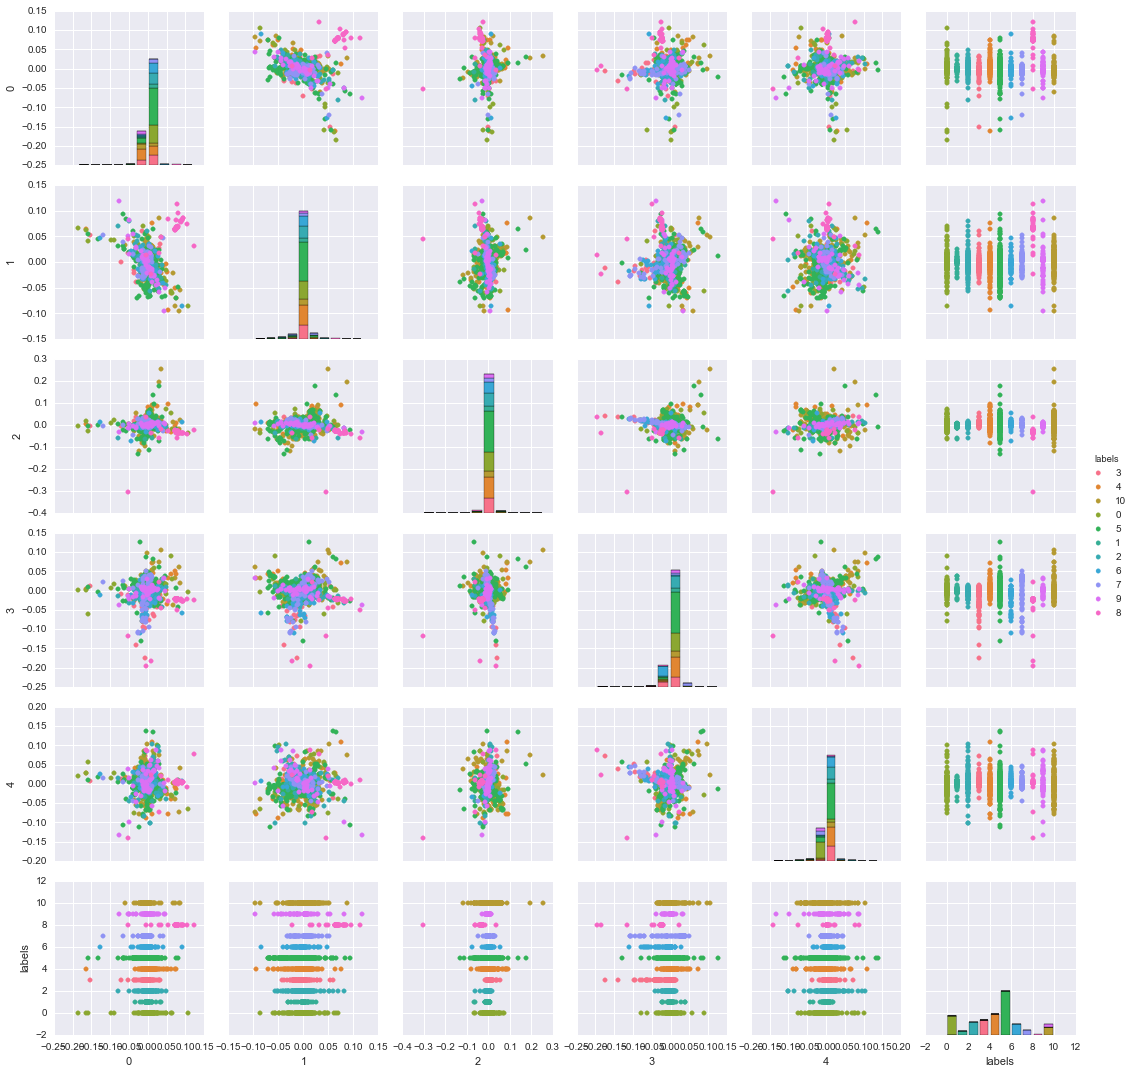

In [17]:
n_clusters = 11
clustering = KMeans(n_clusters=n_clusters)
labels = clustering.fit_predict(u)
df = pd.DataFrame(u[:, :5])
df['labels'] = labels
sns.pairplot(df, hue='labels')